In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [3]:
model = ResNet50(weights = 'imagenet')

Instructions for updating:
Colocations handled automatically by placer.


102967424/102967424 [==============================] - 0s 0us/step


In [5]:
# data 전처리
img = cv.imread("/content/rabbit.jpg")
x = np.reshape(cv.resize(img, (224, 224,)), (1, 224, 224, 3))
x = preprocess_input(x)

In [6]:
preds = model.predict(x)
top5 = decode_predictions(preds, top = 5)[0]
print("예측결과", top5)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


35363/35363 [==============================] - 0s 0us/step
예측결과 [('n02325366', 'wood_rabbit', 0.7427537), ('n02326432', 'hare', 0.24023704), ('n02328150', 'Angora', 0.008815734), ('n01877812', 'wallaby', 0.002689247), ('n02356798', 'fox_squirrel', 0.0012279289)]


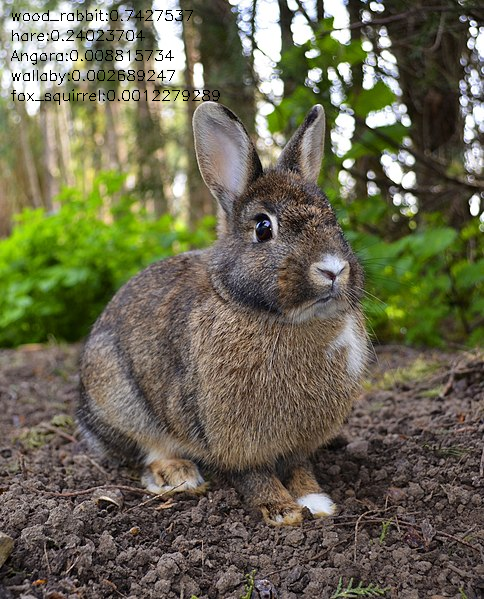

In [7]:
for i in range(5):
  cv.putText(img, top5[i][1] + ':' + str(top5[i][2]), (10, 20+i*20), cv.FONT_HERSHEY_SIMPLEX, 0.5,(0,0,0), 1)

cv2_imshow(img)

In [8]:
cv.waitKey()
cv.destroyAllWindows()

In [9]:
# model 확인
# network 마다 layer name 확인
model.summary()

# 0번째 index가 속한 index
np.argmax(preds[0])

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

330

In [10]:
# 0925
from keras import backend as K

# 예측 벡터의 wood rabbit 항목 -> 330번
wood_rabbit_output = model.output[:, 330]

# Resnet 50의 마지막 층인 conv5_block3_out 의 feature map
last_conv_layer_name = "conv5_block3_out"
last_conv_layer = model.get_layer(last_conv_layer_name)

# 선택한 feature map에 대한 wood rabbit의 gradient
grads = K.gradients(wood_rabbit_output, last_conv_layer.output)[0]
print(grads)

Tensor("gradients/avg_pool/Mean_grad/truediv:0", shape=(None, 7, 7, 2048), dtype=float32)


In [ ]:
# feature map의 채널별 그래디언트 평균 값이 담긴 vector, 각 feature map 별로 평균을 구한다
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# sample image가 주어졌을 때 pooled grads와 wood rabbit의 트ㅡㄱ성 맵 출력을 구한다
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 샘플이미지를 주입하고 두 개의 numpy 배열을 얻는다
pooled_grads_value, conv_layer_output_value = iterate([x])

In [ ]:
# wood rabbit 클래스에 대한 채널의 중요도를 특성 맵 배열의 채널에 곱한다.
# 각각의 feature map 마다 곱셈을 수행한다. -> feature map 수 산정 필요
for i in range(2048):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# x축을 기준으로 heatmap 생성, 축 주의! -> 축에 따라 다른 heatmap 그려질 수 있다.
heatmap = np.mean(conv_layer_output_value, axis = -1)

# heatmap 후처리
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [ ]:
img = cv.imread("/content/rabbit.jpg")

# heatmap을 원본 이미지 크기에 맞게 변경, 하지 않는다면 작은 크기의 heatmap만 사용
heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 rgb format으로 변환
heatmap = np.uint8(255 * heatmap)

# 히트맵 변환
heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)

# heatmap 강도 조절
superimposed_img = heatmap * 0.4 + img

cv2_imshow(superimposed_img)